In [27]:
import pandas as pd
import numpy as np

In [55]:
df = pd.read_csv(
    'https://raw.githubusercontent.com/TeamLab/machine_learning_from_scratch_with_python/master/code/ch12/titanic/train.csv')

In [56]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# 문자열 치환

문자열 치환 - **컴럼 전체 삭제**

In [57]:
df = df.drop(['Name'], axis=1)

In [58]:
df.head(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,female,14.0,1,0,237736,30.0708,NaN,C


문자열 치환 - **라벨 인코딩** : 특정 문자열 데이터를 정수와 매칭하여 단순 변환하는 방식으로 대소 관계에 영향을 주기 때문에 설명 변수에는 잘 사용하지 않는다.

In [59]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['Sex'] = encoder.fit_transform(df['Sex'].values)
df.head(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,1,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,0,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,0,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,1,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,1,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,1,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,1,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,0,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,0,14.0,1,0,237736,30.0708,NaN,C


문자열 치환 - **원핫 인코딩** : 유일한 문자열의 개수만큼 컬럼을 생성하여 그중 하나의 위치에만 1을 대입하는 방식, 일반적인 전처리 방법으로 메모리 낭비가 심하다.

In [60]:
from sklearn.preprocessing import OneHotEncoder

oh_encoder = OneHotEncoder(sparse_output=False)
oh_df = oh_encoder.fit_transform(np.array(df['Embarked']).reshape(-1, 1))

onehot_df = pd.DataFrame(oh_df, columns=["Embarked" + str(int(i)) for i in range(oh_df.shape[1])])
df = df.drop(['Embarked'], axis=1)
df = pd.concat([df, onehot_df], axis=1)
df.head(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked0,Embarked1,Embarked2,Embarked3
0,1,0,3,1,22.0,1,0,A/5 21171,7.2500,NaN,0.0,0.0,1.0,0.0
1,2,1,1,0,38.0,1,0,PC 17599,71.2833,C85,1.0,0.0,0.0,0.0
2,3,1,3,0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0.0,0.0,1.0,0.0
3,4,1,1,0,35.0,1,0,113803,53.1000,C123,0.0,0.0,1.0,0.0
4,5,0,3,1,35.0,0,0,373450,8.0500,NaN,0.0,0.0,1.0,0.0
5,6,0,3,1,NaN,0,0,330877,8.4583,NaN,0.0,1.0,0.0,0.0
6,7,0,1,1,54.0,0,0,17463,51.8625,E46,0.0,0.0,1.0,0.0
7,8,0,3,1,2.0,3,1,349909,21.0750,NaN,0.0,0.0,1.0,0.0
8,9,1,3,0,27.0,0,2,347742,11.1333,NaN,0.0,0.0,1.0,0.0
9,10,1,2,0,14.0,1,0,237736,30.0708,NaN,1.0,0.0,0.0,0.0


문자열 치환 - 기타

In [61]:
df = df.drop(['Ticket'], axis=1)
df = df.drop(['Cabin'], axis=1)
df.head(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked0,Embarked1,Embarked2,Embarked3
0,1,0,3,1,22.0,1,0,7.2500,0.0,0.0,1.0,0.0
1,2,1,1,0,38.0,1,0,71.2833,1.0,0.0,0.0,0.0
2,3,1,3,0,26.0,0,0,7.9250,0.0,0.0,1.0,0.0
3,4,1,1,0,35.0,1,0,53.1000,0.0,0.0,1.0,0.0
4,5,0,3,1,35.0,0,0,8.0500,0.0,0.0,1.0,0.0
5,6,0,3,1,NaN,0,0,8.4583,0.0,1.0,0.0,0.0
6,7,0,1,1,54.0,0,0,51.8625,0.0,0.0,1.0,0.0
7,8,0,3,1,2.0,3,1,21.0750,0.0,0.0,1.0,0.0
8,9,1,3,0,27.0,0,2,11.1333,0.0,0.0,1.0,0.0
9,10,1,2,0,14.0,1,0,30.0708,1.0,0.0,0.0,0.0


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked0    891 non-null    float64
 9   Embarked1    891 non-null    float64
 10  Embarked2    891 non-null    float64
 11  Embarked3    891 non-null    float64
dtypes: float64(6), int64(6)
memory usage: 83.7 KB


# 결측치 처리

## 제거

결측치가 있는 행 혹은 열을 삭제하는 방법입니다. 이 방법은 결측치가 적을 때, 그리고 결측치가 데이터 전체에 대한 비율이 적을 때 사용됩니다.

#### 행 제거

In [37]:
df_drop_row = df.dropna(axis=0)
df_drop_row.info()

<class 'pandas.core.frame.DataFrame'>
Index: 714 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  714 non-null    int64  
 1   Survived     714 non-null    int64  
 2   Pclass       714 non-null    int64  
 3   Sex          714 non-null    int64  
 4   Age          714 non-null    float64
 5   SibSp        714 non-null    int64  
 6   Parch        714 non-null    int64  
 7   Fare         714 non-null    float64
 8   Embarked0    714 non-null    float64
 9   Embarked1    714 non-null    float64
 10  Embarked2    714 non-null    float64
 11  Embarked3    714 non-null    float64
dtypes: float64(6), int64(6)
memory usage: 72.5 KB


#### 열 제거

In [38]:
df_drop_col = df.dropna(axis=1)
df_drop_col.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   Embarked0    891 non-null    float64
 8   Embarked1    891 non-null    float64
 9   Embarked2    891 non-null    float64
 10  Embarked3    891 non-null    float64
dtypes: float64(5), int64(6)
memory usage: 76.7 KB


## 대체

결측치를 다른 값으로 대체하는 방법입니다. 대체하는 방법은 다양하게 있으며, 대표적으로 평균, 중앙값, 최빈값 등으로 대체합니다.

#### 원하는 값으로 대체

In [64]:
df.iloc[3:6, :]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked0,Embarked1,Embarked2,Embarked3
3,4,1,1,0,35.0,1,0,53.1000,0.0,0.0,1.0,0.0
4,5,0,3,1,35.0,0,0,8.0500,0.0,0.0,1.0,0.0
5,6,0,3,1,NaN,0,0,8.4583,0.0,1.0,0.0,0.0


In [65]:
df_fill = df.fillna(0)
df_fill.iloc[3:6, :]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked0,Embarked1,Embarked2,Embarked3
3,4,1,1,0,35.0,1,0,53.1000,0.0,0.0,1.0,0.0
4,5,0,3,1,35.0,0,0,8.0500,0.0,0.0,1.0,0.0
5,6,0,3,1,0.0,0,0,8.4583,0.0,1.0,0.0,0.0


#### 앞 또는 뒤 값으로 대체

In [66]:
df.iloc[4:7, :]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked0,Embarked1,Embarked2,Embarked3
4,5,0,3,1,35.0,0,0,8.0500,0.0,0.0,1.0,0.0
5,6,0,3,1,NaN,0,0,8.4583,0.0,1.0,0.0,0.0
6,7,0,1,1,54.0,0,0,51.8625,0.0,0.0,1.0,0.0


In [67]:
df_fill = df.fillna(method='pad')  # 'pad' : 앞의 값 | 'backfill' : 뒤의 값
df_fill.iloc[4:7, :]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked0,Embarked1,Embarked2,Embarked3
4,5,0,3,1,35.0,0,0,8.0500,0.0,0.0,1.0,0.0
5,6,0,3,1,35.0,0,0,8.4583,0.0,1.0,0.0,0.0
6,7,0,1,1,54.0,0,0,51.8625,0.0,0.0,1.0,0.0


#### 통계적으로 대체
> 평균•최빈값•중앙값

In [43]:
df.iloc[4:7, :]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked0,Embarked1,Embarked2,Embarked3
4,5,0,3,1,35.0,0,0,8.0500,0.0,0.0,1.0,0.0
5,6,0,3,1,NaN,0,0,8.4583,0.0,1.0,0.0,0.0
6,7,0,1,1,54.0,0,0,51.8625,0.0,0.0,1.0,0.0


In [68]:
df_fill = df.fillna(df.mean())  # df.mean() : 평균값 | df.median() : 중앙값 | df[{feature}].mode()[0] : 최빈값
df_fill.iloc[4:7, :]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked0,Embarked1,Embarked2,Embarked3
4,5,0,3,1,35.000000,0,0,8.0500,0.0,0.0,1.0,0.0
5,6,0,3,1,29.699118,0,0,8.4583,0.0,1.0,0.0,0.0
6,7,0,1,1,54.000000,0,0,51.8625,0.0,0.0,1.0,0.0


**일단 간단하게 행 제거를 사용하도록 하겠다.**

In [45]:
df = df.dropna(axis=0)

# 차원 축소

차원축소를 해야하는 가장 큰 이유는 차원의 저주(curse of dimension) 때문입니다. 차원의 저주란 데이터 학습을 위한 차원(특성)이 증가하면 서 모델의 성능이 떨어지는 현상을 말합니다.

## 특성 선택

Feature Selection(특성 선택)은 data set 에서 유의미한 특성을 선택하는 과정입니다. 학습에 악영향을 미치는 불필요한 특성을 제거하여 모델의 복잡성을 감소시켜, 과적합 방지와 모델성능 향상의 효과가 있습니다.

[ 대표적인 특성 선택의 종류 ]
- 해당 도매인의 지식을 이용
- 피어슨 상관계수(Pearson correlation)
- 랜덤 포레스트 특성 중요도(Random Forest Feature Importance)
- Lasso

### 피어슨 상관계수

피어슨 상관계수는 두 변수 간 선형적인 상관관계의 정도를 나타내는 지표입니다.

-1 ~ 1의 값을 가지며 절대값이 클수록 높은 상관관계를, 0에 가까울수록 낮은 상관관계를 나타냅니다.

<Axes: >

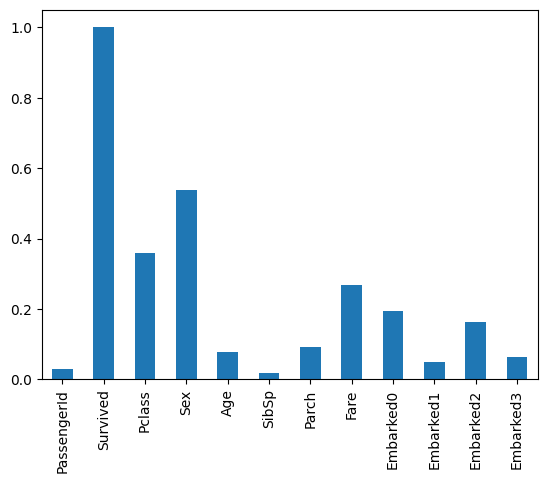

In [46]:
df.corr()['Survived'].abs().plot.bar()

### 랜덤 포레스트 특성 중요도

Random Forest의 Feature Importance는 각 feature의 기여도를 나타내는 지표입니다.

Feature Importance가 높은 feature일수록 예측 모델에 중요한 역할 한다고 해석할 수 있습니다.

<BarContainer object of 11 artists>

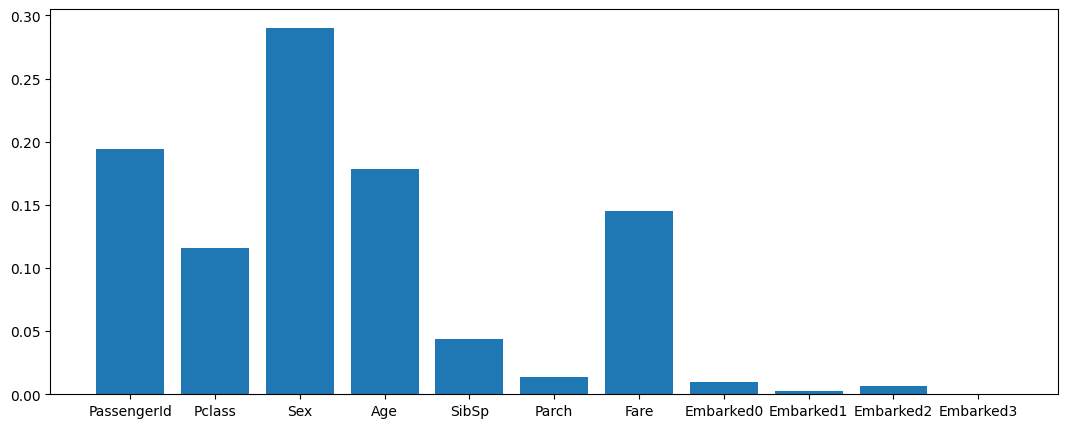

In [47]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

df_x = df.drop(['Survived'], axis=1)
df_y = df['Survived']

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(df_x, df_y)

# 학습된 모델의 feature importance 확인
importance = rf_model.feature_importances_
plt.figure(figsize=(13, 5))
plt.bar(df_x.columns, importance)

### LASSO

Lasso 모델에서는 L1 규제를 사용 하기 때문에, 일부 feature의 계수 를 0으로 만들어 해당 feature를 모델에서 제외시키는 효과가 있 습니다.

따라서 계수가 0이 아닌 feature일 수록 해당 모델에 기여한 정도가 크다고 해석할 수 있습니다.

<BarContainer object of 11 artists>

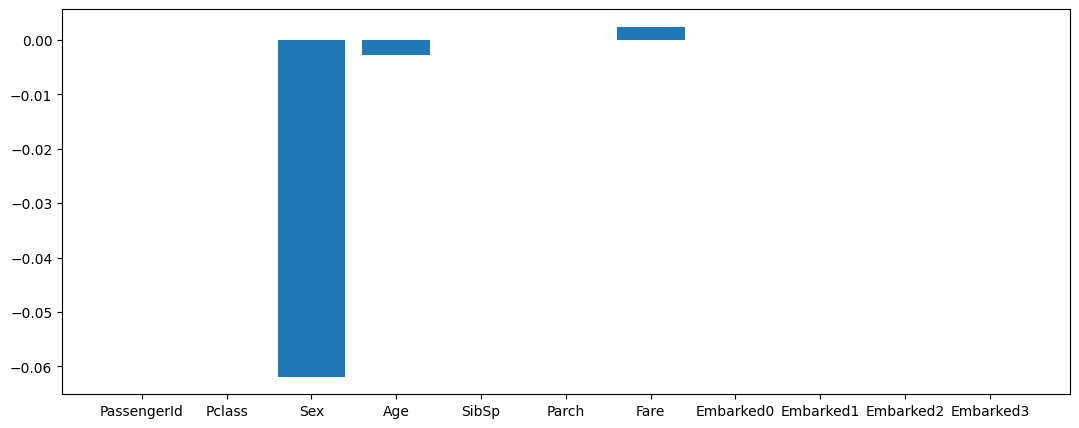

In [48]:
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

df_x = df.drop(['Survived'], axis=1)
df_y = df['Survived']

lasso_model = Lasso(alpha=0.1)  # alpha -> 규제 강도 설정 매개변수
lasso_model.fit(df_x, df_y)

# 학습된 모델을 사용하여 예측 수행
y_pred = lasso_model.predict(df_x)

# 학습된 모델의 feature importance 확인
importance = lasso_model.coef_
plt.figure(figsize=(13, 5))
plt.bar(df_x.columns, importance)

## 특성 추출

Feature Extraction(특성 추출)은 데이터에서 의미 있는 정보를 추출하여 새로운feature를생성하는과정입니다. FeatureExtraction은특히고차 원 데이터에서 유용합니다.

[ 대표적인 특성 추출 종류 ]
- PCA(주성분 분석)
- LDA(선형 판별 분석)

### PCA

주어진 데이터의 주요한 정보를 나타 내는 새로운 feature를 추출하여 차원을 축소합니다.

이러한 feature를 주성분이라고 하며, PCA를 통해 데이터를 잘 표현하는 k개의 주성분을 추출하여 데이터를 k차원으로 축소할 수 있습니다.

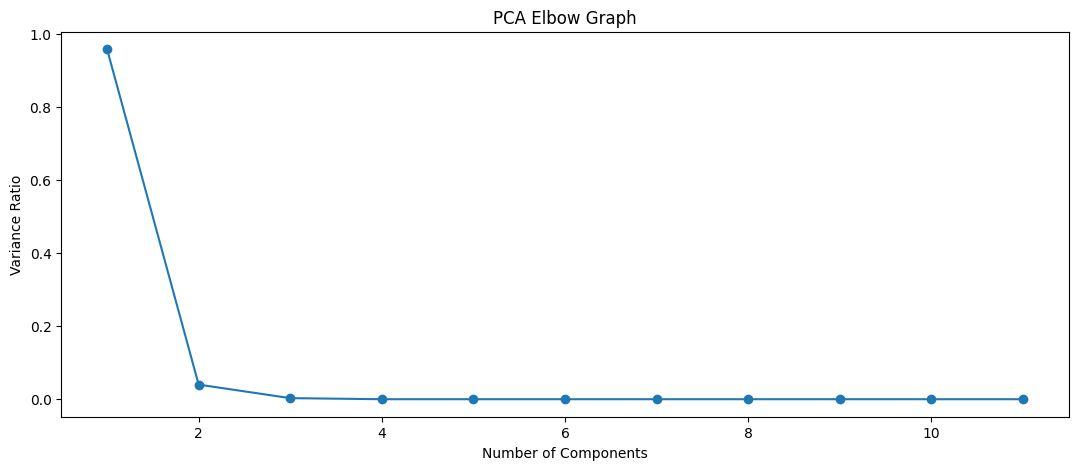

In [49]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

df_x = df.drop(['Survived'], axis=1)
pca = PCA()

# variance ratio 계산
pca.fit(df_x)
variance_ratio = pca.explained_variance_ratio_

# elbow 그래프 그리기
plt.figure(figsize=(13, 5))
plt.plot(range(1, len(variance_ratio) + 1), variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Variance Ratio')
plt.title('PCA Elbow Graph')
plt.show()

### LDA

분류 문제에서 차원원 축소를 위해 사용되는 방법으로, PCA와는 달리 클래스 간 분산과 클래스 내 분산을 모두 고려합니다.

In [50]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

# 예시 데이터 로드
df_x = df.drop(['Survived'], axis=1)

#LDA 모델 생성 및 variance ratio 계산
lda = LinearDiscriminantAnalysis()
lda.fit(df_x, df_y)

print('LDA설명률 : ', lda.explained_variance_ratio_)
df_x = lda.transform(df_x)

LDA설명률 :  [1.]


# 피처 스케일링

특성(피처)들의 값을 일정한 수준으로 맞춰주는 것이 피처 스케일링이라 불립니다. 특성마다 분산, 범위 등 다양한 통계학적 특성이 다르기 때문에, 각 특성을 비교 분석하기가 힘들고 학습에 악영향을 줍니다.

[ 피처 스케일링 종류 ]
- 표준화
- 정규화

## 표준화

표준화의 목적은 데이터 셋의 numerical value의 범위를 파라미터로 설정한 평균과 분산이 되도록 하는 방법입니다.

### Standard Scaler

대표적인 표준화 방법입니다. 특성별로 데이터를 정규분포(평균 0, 분산 1)로 변경합니다.

In [51]:
from sklearn.preprocessing import StandardScaler

Scaler = StandardScaler()
df_standard = Scaler.fit_transform(df)

df_standard[0:2]

array([[-1.72853202, -0.82702011,  0.91123237,  0.75905134, -0.53037664,
         0.52457013, -0.50589515, -0.51897787, -0.47180795, -0.20203051,
         0.53740921, -0.05299989],
       [-1.7246701 ,  1.20916044, -1.47636364, -1.31743394,  0.57183099,
         0.52457013, -0.50589515,  0.69189675,  2.11950647, -0.20203051,
        -1.86077941, -0.05299989]])

#### 시각화

Text(0.5, 1.0, 'After')

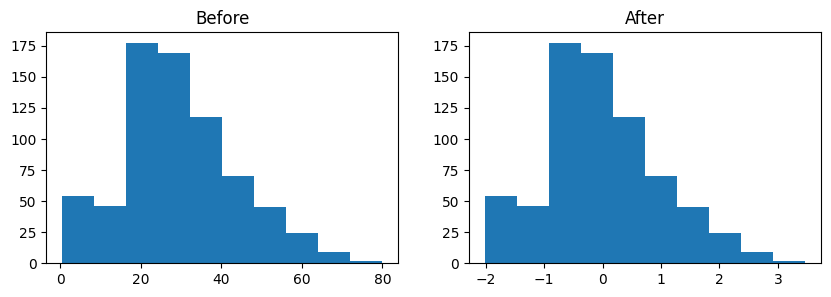

In [52]:
import matplotlib.pyplot as pit

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].hist(df.iloc[:, 4])
axs[0].set_title('Before')

axs[1].hist(df_standard[:, 4])
axs[1].set_title('After')

## 정규화

정규화의 목적은 데이터 셋의 numerical value 범위를 사용자가 설정한 공통 척도로 변경하는 것입니다.

### MinMax Scaler

대표적인 정규화 방법입니다. 특성별로 데이터를 0 ~ 1 범위로 변경합니다.

In [53]:
from sklearn.preprocessing import MinMaxScaler

Scaler = MinMaxScaler()
df_MinMax = Scaler.fit_transform(df)

df_MinMax[0:2]

array([[0.        , 0.        , 1.        , 1.        , 0.27117366,
        0.2       , 0.        , 0.01415106, 0.        , 0.        ,
        1.        , 0.        ],
       [0.0011236 , 1.        , 0.        , 0.        , 0.4722292 ,
        0.2       , 0.        , 0.13913574, 1.        , 0.        ,
        0.        , 0.        ]])

#### 시각화

Text(0.5, 1.0, 'After')

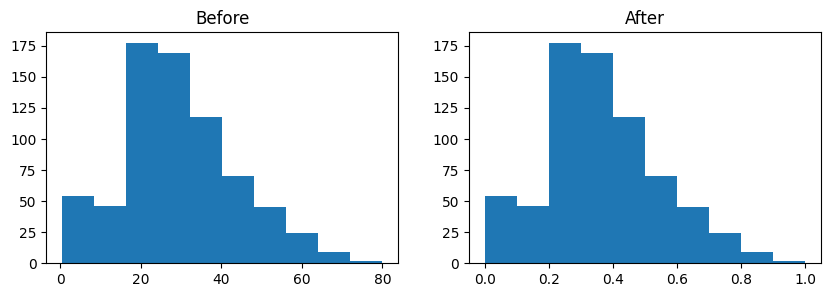

In [54]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].hist(df.iloc[:, 4])
axs[0].set_title('Before')

axs[1].hist(df_MinMax[:, 4])
axs[1].set_title('After')